#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

**План работы.**

- Подготовка данных.
- Анализ данных.
    - Декомпозиция.
    - Проверка на стационарность.
- Подготовка признаков для моделирования.
- Обучение моделей.
    - `DecisionTreeRegressor`;
    - `RandomForestRegressor`;
    - `SGDRegressor`;
    - `LGBMRegressor`;
    - `Полносвязанная нейронная сеть`.
- Тестирование лучшей модели.
- Вывод.

## Подготовка данных для исследования

**Импорт необходимых библиотек.**

In [1]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy
from math import ceil

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor

import torch
import torch.nn as nn

pd.set_option('display.max_columns', None)

warnings.filterwarnings('ignore')

RANDOM = 1234
np.random.seed(RANDOM)
torch.manual_seed(RANDOM)
torch.use_deterministic_algorithms(True)

**Загрузка датасета**

In [2]:
try:
    data = pd.read_csv("/datasets/taxi.csv")
except FileNotFoundError:
    data = pd.read_csv("https://code.s3.yandex.net/datasets/taxi.csv")

**Информация по датасету.**

In [3]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


**Преобразование типов данных.**

Как видно выше из информации по датасету:

- данные по заказам представлены за 10 минутный интервал;
- пропуски в данных отсутсвуют;

Столбец `datetime` будет преобразован в тип данных `datetime(64)`. Он же станет индексом и будет отсортирован по возрастанию индекса

In [5]:
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)
data = data.sort_index()

**Проверка хронологического порядка расположения даты и времени.**

In [6]:
print(data.index.is_monotonic_increasing)

True


Порядок соблюдён, атрибут вернул значение `True`.

**Ресемплирование.**

Согласно условию ресемплирование дожно быть по 1 часу.

In [7]:
data = data.resample('1H').sum()

In [8]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.422781,45.023853,0.0,54.0,78.0,107.0,462.0


Минимум заказов 0, максмимум 462.

In [9]:
data['num_orders'] = data['num_orders'].astype('int32')

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int32
dtypes: int32(1)
memory usage: 51.8 KB


**Вывод**

Данные подготовлены к анализу.

## Анализ данных

**Временной ряд количества заказов за весь период наблюдений.**

Функция для визуализации временного ряда и декомпозиции.

In [11]:
def visualisation(data,
                  decomp=False,
                  trend=True,
                  seasonal=True,
                  resid=True,
                  start=None,
                  end=None):
    '''
    Функция  для визуализации временного ряда и декомпозиции.
    
    Параметры:
     
     data: датасет с данными,
     decomp: флаг декомпозиции, по умолчанию - False, если True, 
             будет выведен графический результат декомпозиции, если False - просто график временного ряда,
     trend: по умолчанию True, при выборе decomp=True и trend=True будет показана декомпозиция по тренду,
     seasonal: по умолчанию True, при выборе decomp=True и seasonal=True будет показана декомпозиция по сезонности,
     resid: по умолчанию True, при выборе decomp=True и resid=True будет показана декомпозиция по остаткам,
     start: начало среза для вывода (например: '2018-08-01'), по умолчанию False,
     end: конец среза для вывода (например: '2018-08-31'), по умолчанию False.
              
    '''
    
    # проверка флага decomp на значение True, если да, то вывод декомпозиции.
    if decomp:
        
        decomposed = seasonal_decompose(data[start:end])

        # проверка флага trend на значение True, если да и decomp да, то вывод декомпозиции по тренду.
        if trend:

            plt.figure(figsize=(12, 8))
            plt.subplot(311)
            decomposed.trend.plot(ax=plt.gca())
            plt.title('Тренд', fontsize=18)
            plt.xlabel('Временной интервал', fontsize=15, color='blue')
            plt.ylabel('Кол-во', fontsize=15, color='blue')
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)
            plt.legend(fontsize=14)
            plt.grid(True)
            plt.tight_layout()

        # проверка флага seasonal на значение True, если да и decomp да, то вывод декомпозиции по сезонности.   
        if seasonal:

            plt.figure(figsize=(12, 8))
            plt.subplot(312)
            decomposed.seasonal.plot(ax=plt.gca())
            plt.title('Сезонность', fontsize=18)
            plt.xlabel('Временной интервал', fontsize=15, color='blue')
            plt.ylabel('Кол-во', fontsize=15, color='blue')
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)
            plt.grid(True)
            plt.tight_layout()
            
        # проверка флага resid на значение True, если да и decomp да, то вывод декомпозиции по остаткам.
        if resid:

            plt.figure(figsize=(12, 8))
            plt.subplot(313)
            decomposed.resid.plot(ax=plt.gca())
            plt.title('Остаток декомпозиции', fontsize=18)
            plt.xlabel('Временной интервал', fontsize=15, color='blue')
            plt.ylabel('Кол-во', fontsize=15, color='blue')
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)
            plt.grid(True)

            plt.tight_layout()
            
    # проверка флага decomp на значение True, если нет, то вывод графика временного ряда.
    else:

        data.plot(figsize=(16, 8))
        plt.title('Временной ряд количества заказов весна-лето 2018',
                  fontsize=20)
        plt.xlabel('Дата', fontsize=18, color='blue')
        plt.ylabel('Количество', fontsize=18, color='blue')
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.legend(fontsize=14)
        plt.grid(True)

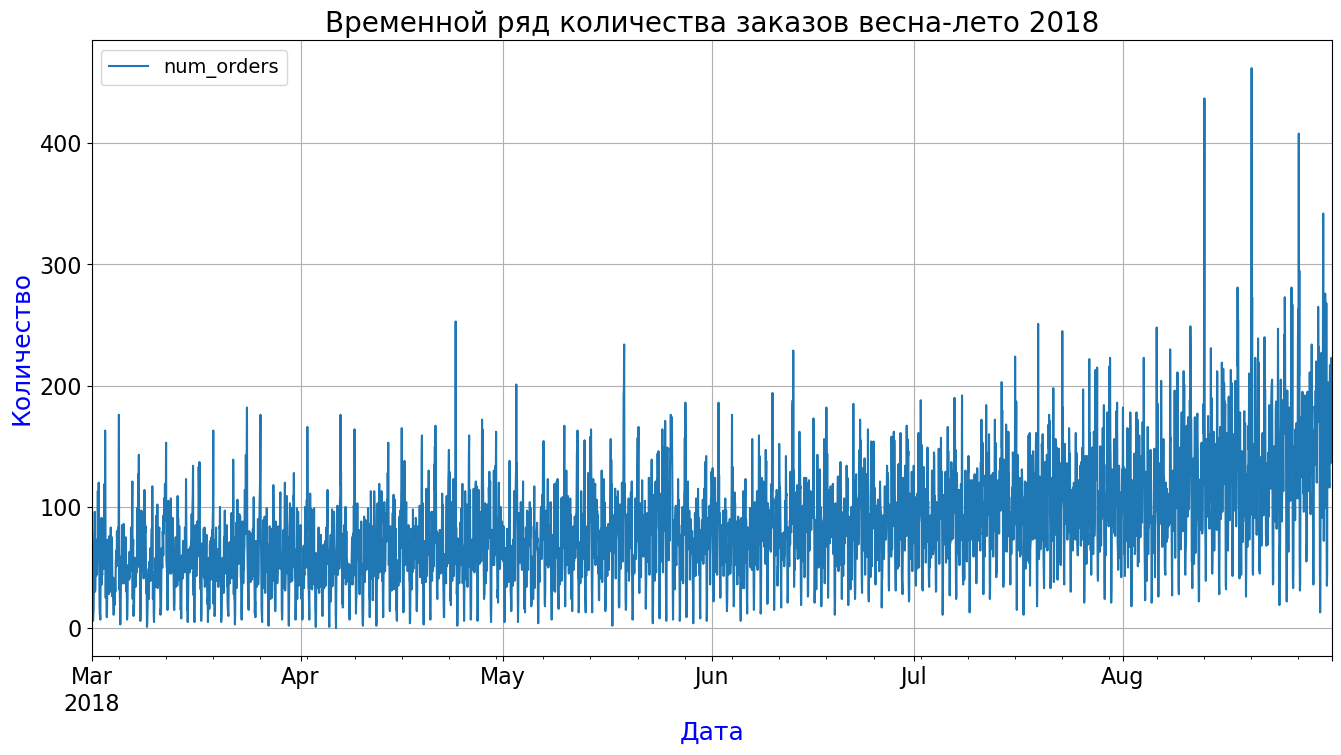

In [12]:
visualisation(data, decomp=False)

Имеются колебания значений с тенденцией на повышение заказов в течение рассматриваемого периода. 

Так же видны пиковые значения. Скорее всего эти значения пояляются в определенные дни и часы.

Ниже проведем декомпозицию для выявления всех закономерностей.

**Декомпозиция по всему датасету с марта по август 2018.**

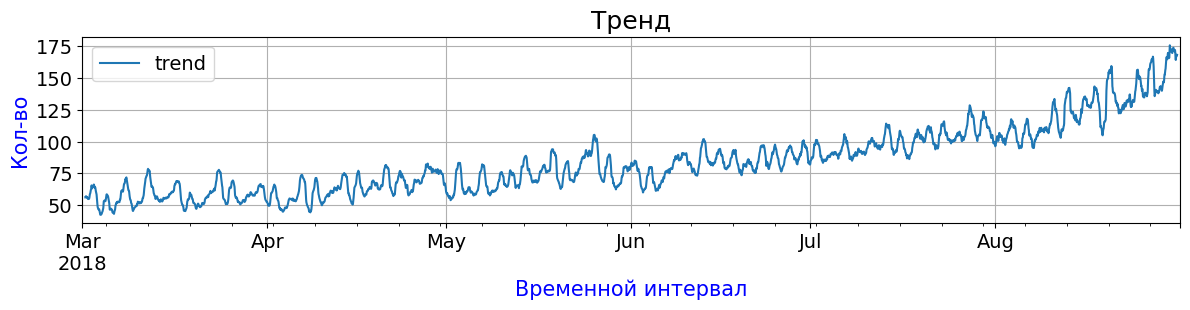

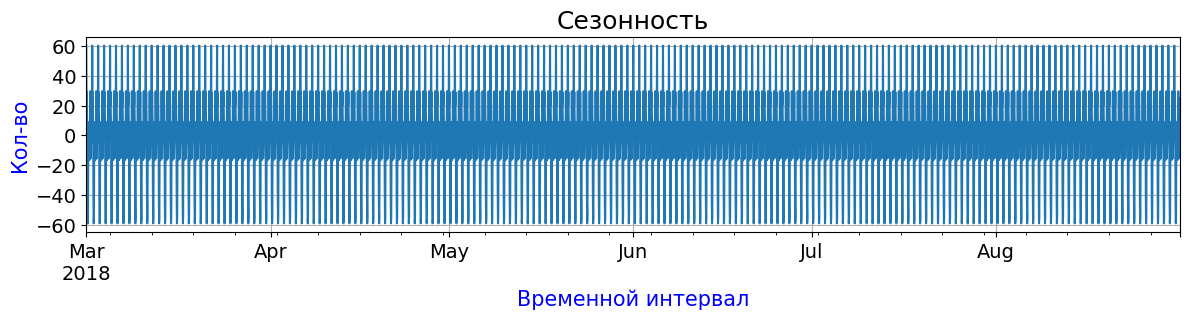

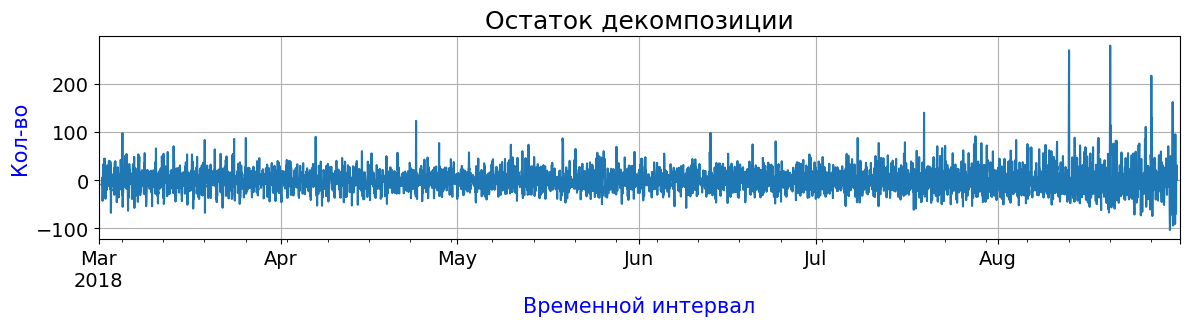

In [13]:
visualisation(data, decomp=True)

В результате видим слабовосходящий тренд:
- весна: тренд практически отсутствует,
- лето: идет рост с усилением тренда в августе.

График сезонности слишком концентрированный, но цикличность прослеживается.

Остатки идут более или менее ровно. В агусте начинается разброс значений.


Более детально исследуем самый трендовый месяц - август.

**Декомпозиция по августу 2018 по тренду и сезонности.**

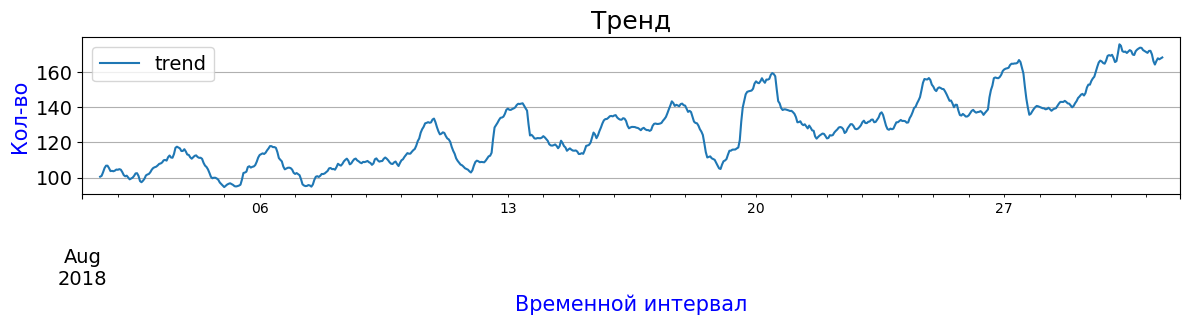

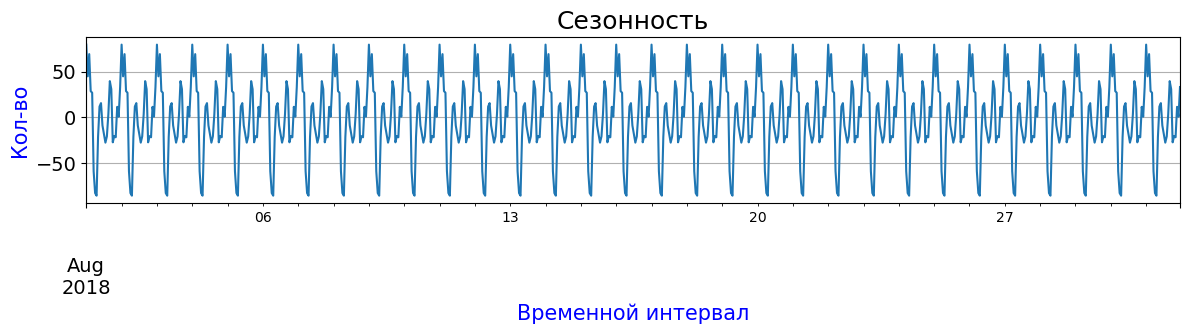

In [14]:
visualisation(data, decomp=True, resid=False, start='2018-08-01', end='2018-08-31')

По августу виден рост со 100 заказов до 180 приблизительно. 

Первая неделя слабенькая, далее еженедельный рост.

Визуально наблюдается падение заказов в понедельник-вторник, среда-пятница растет, суббота резкое падение, воскресение - рост.

В сезонности - цикличность.

Детализируем одну из недель с ростом заказов.

**Декомпозиция по отдельно взятой неделе августа 2018 года по тренду и сезонности.**

Для визуализации взята неделя с 20 по 27 августа, где 20 августа - понедельник, 26 августа - воскресение.

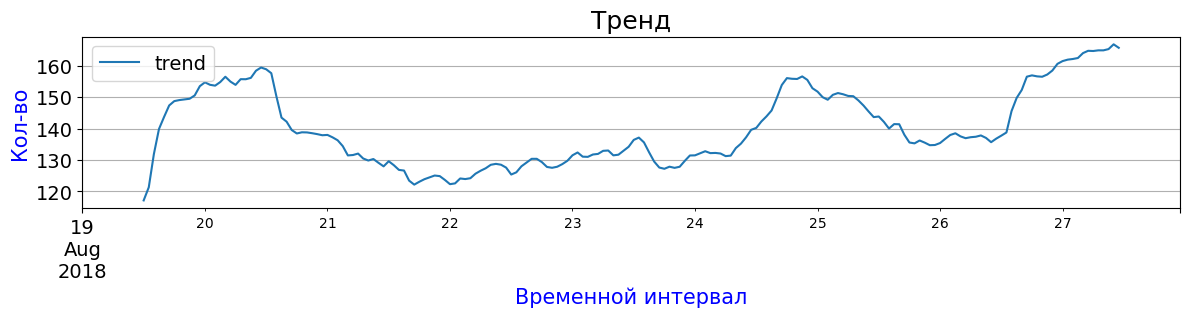

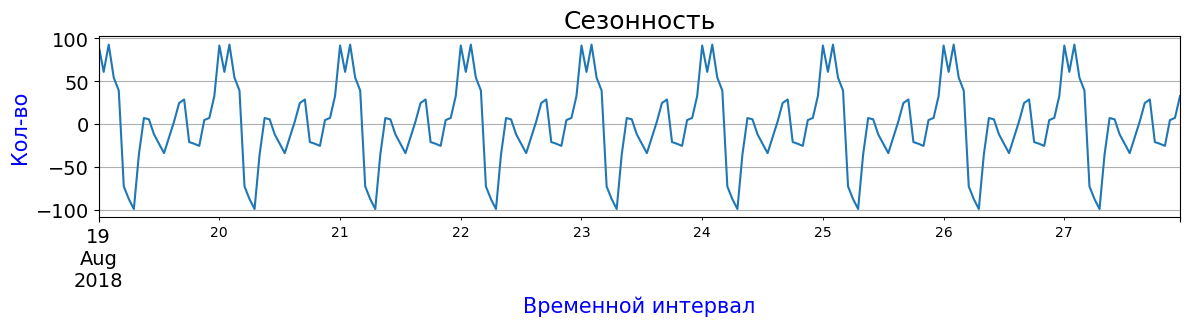

In [15]:
visualisation(data, decomp=True, resid=False, start='2018-08-19', end='2018-08-27')

Сезонность - циклична.

По тренду как и было сказано ранее:

- понедельник - полдня рост, затем падение;
- вторник - падение; 
- среда - плавный небольшой рост;
- четверг - практически на месте с ростовыми колебаниями;
- пятница - рост; 
- суббота - резкое падение; 
- воскресение - рост.

Детализируем период с пятницы по воскресение и захватим понедельник следующей недели.

**Декомпозиция с 24-08-2018 по  27-08-2018 года по тренду.**

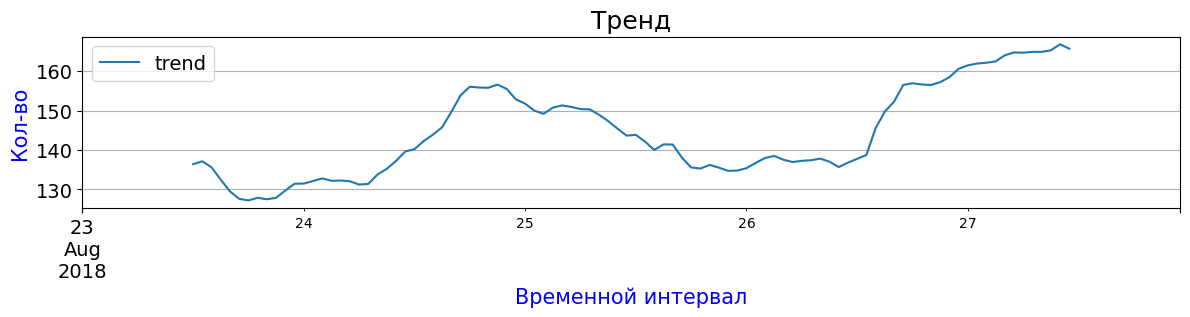

In [16]:
visualisation(data, decomp=True, seasonal=False, resid=False, start='2018-08-23', end='2018-08-27')

Итак:

- Пятница 24-08 - рост с 6-7 утра и практически до 10 вечера (скорее всего люди улетают-прилетают на выходные/отпуска);
- Суббота 25-08 - падение практически весь день (улетают- прилетают в ночь, далее спад);
- Воскресение 26-08 - до 12 часов затишье, далее реззкий рост аж до 12 понедельника следующего дня (возврат с отдыха + командировочные и т.п.)

**Промежуточный вывод**

Исходя из анализа по декомпозиции можно выделить дополнительные признаки для моделирования (хотя данные имеются всего за 6 месяцев одного года):

- номер месяца;
- номер недели:
- день недели;
- час внутри дня.

**Проверка на стационарность.**

Стационарный временной ряд - это ряд, у которого среднее и стандартное отклонение не меняются. Когда среднее и стандартное отклонение первого ряда меняется медленнее второго, то первый ряд «более стационарный», чем второй.

Добавим на график среднее и стандартное отклонение.

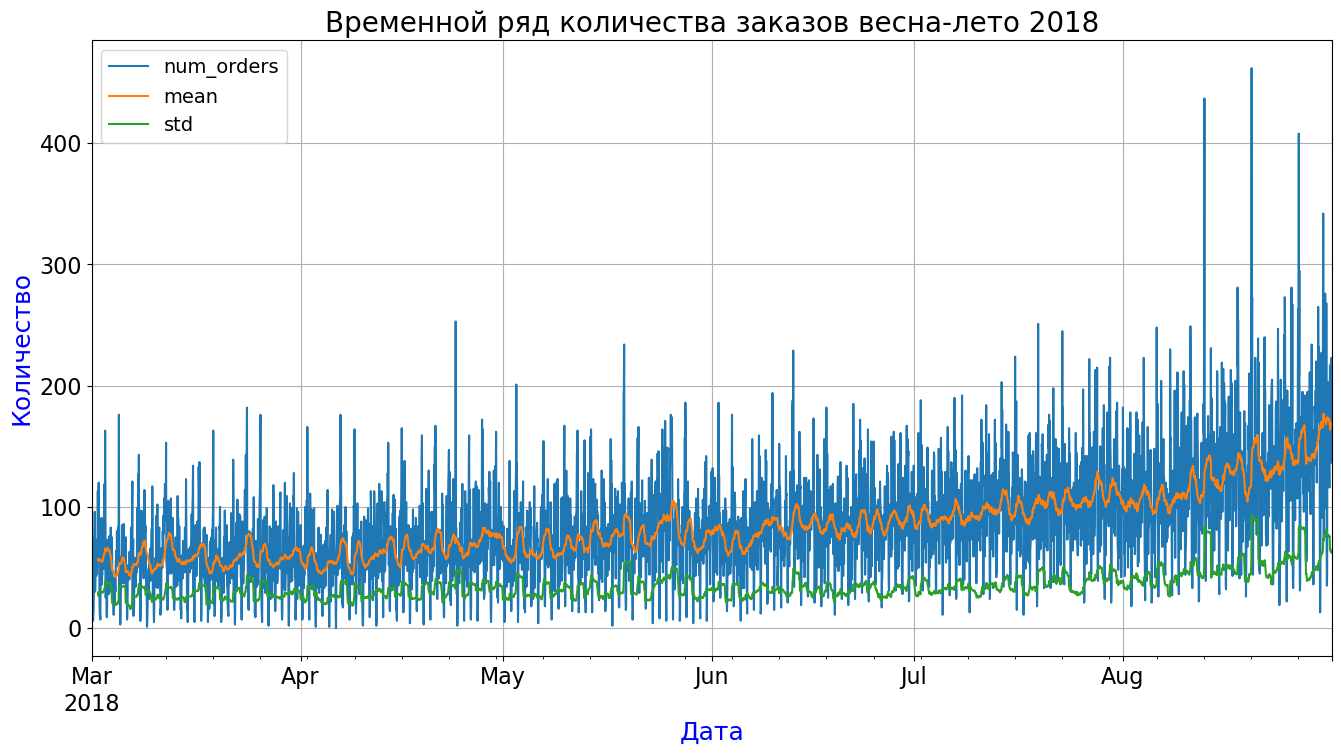

In [17]:
data['mean'] = data['num_orders'].rolling(24).mean()
data['std'] = data['num_orders'].rolling(24).std()
visualisation(data, decomp=False)
data = data.drop(['mean', 'std'], axis=1)

Визуально ряд выглядит нестационарным. Как минимм видно увеличение среднего значения.

Один из способов проверить, является ли временной ряд стационарным, — это выполнить расширенный тест Дики-Фуллера , в котором используются следующие нулевая и альтернативная гипотезы:

- $H_{0}$ - временной ряд является нестационарным, т.е он имеет некоторую структуру, зависящую от времени, и не имеет постоянной дисперсии во времени.

- $H_{A}$ - временной ряд является стационарным.

Если `p-value` из теста меньше уровня значимости `α = 0.05`, то можно отвергнуть нулевую гипотезу и сделать вывод, что временной ряд является стационарным.

In [18]:
test = adfuller(data)

print('ADF Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Количество использованных лагов: %0.f' % test[2])
print('Critical Values:')

for key, value in test[4].items():
    print('\t%s: %.3f' % (key, value))

if test[0] > test[4]['5%']: 
    print('Eсть единичные корни, ряд не стационарен.')
else:
    print('Eдиничных корней нет, ряд стационарен.')

ADF Statistic: -3.068924
p-value: 0.028940
Количество использованных лагов: 30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Eдиничных корней нет, ряд стационарен.


`p-value` меньше порогового значения 0.05, значит можно отвергнуть нулевую гипотезу, что ряд нестационарный, и соответственно ряд стационарный.

## Подготовка признаков для моделирования 

Новые признаки:

- месяц;
- день;
- день недели;
- час;
- лаги;
- скользящее среднее.
- скользящее среднее по последниму лагу.


Месяц, день, день недели и час будут выделены из даты, которая является индексом.

Количество лагов - 7.

Скользящее среднее будет экспоненциально сглаженное по 7 периодам.

Так же будет добавлен признак со скользящим средним по последнему лагу.

In [19]:
def make_features(data, max_lag=7, ema_period=7):
    
    '''
    Функция разбивает датасет на выборки.
    
    Параметры:
    
     data: датасет с данными,
     max_lag: количество лагов, по умолчанию 7, 
     ema_period: период для exponential moving average, по умолчанию 7, 
          
    Возвращаемое значение:
     
     data_copy: датасет с признаками
      
    '''

    data_copy = data.copy(deep=True)
    # выделение номера месяца 
    data_copy['month'] = data_copy.index.month
    # выделение номера дня
    data_copy['day'] = data_copy.index.day
    # выделение номера дня недели
    data_copy['dayofweek'] = data_copy.index.dayofweek
    # выделение часа
    data_copy['hour'] = data_copy.index.hour
    
 
    # добавление лагов    
    for lag in range(1, max_lag + 1):
        data_copy['lag_{}'.format(lag)] = data_copy['num_orders'].shift(lag)
 
    # скользящее среднее по последнему лагу
    data_copy['max_lag_mean'] = data_copy['lag_{}'.format(max_lag)].rolling(ema_period).mean()

    # добавление exponential moving average
    data_copy['EMA'] = data_copy['num_orders'].ewm(ema_period).mean()
    
    return data_copy

**Создание признаков и удаление пропусков.**

In [20]:
data_hour = make_features(data, max_lag=7)
data_hour = data_hour.dropna()

**Вывод первых трех строк датасета с созданными признаками.**

In [21]:
data_hour.head(3)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,max_lag_mean,EMA
datetime,,,,,,,,,,,,,,
2018-03-01 13:00:00,32,3,1,3,13,30.0,96.0,64.0,69.0,34.0,15.0,12.0,58.142857,49.011202
2018-03-01 14:00:00,48,3,1,3,14,32.0,30.0,96.0,64.0,69.0,34.0,15.0,42.571429,48.865086
2018-03-01 15:00:00,66,3,1,3,15,48.0,32.0,30.0,96.0,64.0,69.0,34.0,35.285714,51.293688


## Обучение моделей

**Функция для разбиения датасета на выборки.**

In [22]:
def data_split(data, test_size=0.1, valid=False, test_valid_size=0.2):
    '''
    Функция разбивает датасет на выборки.

    Параметры:

     data: датасет с данными,
     test_size: размер тестовой выборки, по умолчанию 10% или 0.1, 
     valid: флаг для выбора возможности добавлять валидационную выборку, 
     test_valid_size: размер тестовой и валидационной выборки, по умолчанию 20% или 0.2, в дальнейшем 
                      выборки будут разбиты 50 на 50.

    Возвращаемое значение (результат разбиения на выборки):

     Если valid=False, возвращаются только трейн и тест:

       features_train, target_train, features_test, target_test

     Если valid=Екгу, возвращаются трейн, валид и тест:

       features_train, target_train, features_valid, target_valid, features_test, target_test

    '''

    # выделение признаков
    features = data_hour.drop(['num_orders'], axis=1)
    # выделение целевого признака
    target = data_hour['num_orders']

    # если нужна валидация - разбиваем на train, valid, test в соотношении 80-10-10
    if valid:

        features_train, features_test, target_train, target_test = train_test_split(
            features, target, test_size=test_valid_size, random_state=RANDOM, shuffle=False)
        features_valid, features_test, target_valid, target_test = train_test_split(
            features_test, target_test, test_size=.5, random_state=RANDOM, shuffle=False)

        print('Тренировочная выборка: ',
              features_train.shape, target_train.shape)
        print('Начальный индекс: ', features_train.index.min(),
              'Конечный индекс:', features_train.index.max())
        print('Валидационная выборка: ',
              features_valid.shape, target_valid.shape)
        print('Начальный индекс: ', features_valid.index.min(),
              'Конечный индекс:', features_valid.index.max())
        print('Тестовая выборка: ', features_test.shape, target_test.shape)
        print('Начальный индекс: ', features_test.index.min(),
              'Конечный индекс:', features_test.index.max())

        return features_train, target_train, features_valid, target_valid, features_test, target_test

    # если не нужна валидация - разбиваем на train и test в соотношении 90-10
    else:

        features_train, features_test, target_train, target_test = train_test_split(
            features, target, test_size=test_size, random_state=RANDOM, shuffle=False)

        print('Тренировочная выборка: ',
              features_train.shape, target_train.shape)
        print('Начальный индекс: ', features_train.index.min(),
              'Конечный индекс:', features_train.index.max())
        print('Тестовая выборка: ', features_test.shape, target_test.shape)
        print('Начальный индекс: ', features_test.index.min(),
              'Конечный индекс:', features_test.index.max())

        return features_train, target_train, features_test, target_test

Разбиение датасета на трейн и тест в соотношении 90% на 10%.

In [23]:
features_train, target_train, features_test, target_test = data_split(
    data_hour)

Тренировочная выборка:  (3962, 13) (3962,)
Начальный индекс:  2018-03-01 13:00:00 Конечный индекс: 2018-08-13 14:00:00
Тестовая выборка:  (441, 13) (441,)
Начальный индекс:  2018-08-13 15:00:00 Конечный индекс: 2018-08-31 23:00:00


В обучении будут использованы 5 моделей:

- `DecisionTreeRegressor`;
- `RandomForestRegressor`;
- `SGDRegressor`;
- `LGBMRegressor`;
- `Полносвязанная нейронная сеть`.

### DecisionTreeRegressor

**Инициализация модели.**

In [24]:
model_tree = DecisionTreeRegressor(random_state=RANDOM)

**Сетка с параметрами модели.**

In [25]:
param_grid_tree = {
    'decisiontreeregressor__max_depth': np.arange(1, 12, 2),
    'decisiontreeregressor__min_samples_split': np.arange(1, 12, 2),
    'decisiontreeregressor__min_samples_leaf': np.arange(1, 16, 2),
}

**Пайплайн для модели с использованием `MinMaxScaler()`.**

In [26]:
pipe_tree = make_pipeline(MinMaxScaler(), model_tree)

**Параметр для кроссвалидации**

Будет использован для всех базовых моделей.

In [27]:
cv = TimeSeriesSplit(n_splits=10)

**Финальная сборка модели.**

In [28]:
tree_final = GridSearchCV(pipe_tree,
                          param_grid_tree,
                          scoring='neg_root_mean_squared_error',
                          cv=cv,
                          n_jobs=-1)

**Обучение модели.**

In [29]:
tree_final.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor(random_state=1234))]),
             n_jobs=-1,
             param_grid={'decisiontreeregressor__max_depth': array([ 1,  3,  5,  7,  9, 11]),
                         'decisiontreeregressor__min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15]),
                         'decisiontreeregressor__min_samples_split': array([ 1,  3,  5,  7,  9, 11])},
             scoring='neg_root_mean_squared_error')

**Результат.**

In [30]:
rmse_tree = round(np.abs(tree_final.best_score_), 2)
print(
    f"RMSE на тренировочной выборке с кроссвалидацией --> {rmse_tree},\nЛучшие гиперпараметры: {tree_final.best_params_}"
)

RMSE на тренировочной выборке с кроссвалидацией --> 26.3,
Лучшие гиперпараметры: {'decisiontreeregressor__max_depth': 5, 'decisiontreeregressor__min_samples_leaf': 7, 'decisiontreeregressor__min_samples_split': 3}


### RandomForestRegressor

**Инициализация модели.**

In [31]:
model_forest = RandomForestRegressor(random_state=RANDOM)

**Сетка с параметрами модели.**

In [32]:
param_grid_forest = {
    'randomforestregressor__max_depth': np.arange(1, 12, 2),
    'randomforestregressor__min_samples_split': np.arange(1, 12, 2),
    'randomforestregressor__min_samples_leaf': np.arange(1, 16, 2)
}

**Пайплайн для модели с использованием `MinMaxScaler()`.**

In [33]:
pipe_forest = make_pipeline(MinMaxScaler(), model_forest)

**Финальная сборка модели.**

In [34]:
forest_final = GridSearchCV(pipe_forest,
                            param_grid_forest,
                            scoring='neg_root_mean_squared_error',
                            cv=cv,
                            n_jobs=-1)

**Обучение модели.**

In [35]:
forest_final.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=1234))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': array([ 1,  3,  5,  7,  9, 11]),
                         'randomforestregressor__min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15]),
                         'randomforestregressor__min_samples_split': array([ 1,  3,  5,  7,  9, 11])},
             scoring='neg_root_mean_squared_error')

**Результат.**

In [36]:
rmse_forest = round(np.abs(forest_final.best_score_), 2)
print(
    f"RMSE на тренировочной выборке с кроссвалидацией --> {rmse_forest},\nЛучшие гиперпараметры: {forest_final.best_params_}"
)

RMSE на тренировочной выборке с кроссвалидацией --> 21.63,
Лучшие гиперпараметры: {'randomforestregressor__max_depth': 11, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 5}


### SGDRegressor

**Инициализация модели.**

In [37]:
model_sgd = SGDRegressor(random_state=RANDOM)

**Сетка с параметрами модели.**

In [38]:
param_grid_sgd = {
    'sgdregressor__penalty': ['l2', 'elasticnet'],
    'sgdregressor__alpha': [0.0001, 0.001, 0.01],
    'sgdregressor__max_iter': [10000, 15000]
}

**Пайплайн для модели с использованием `MinMaxScaler()`.**

In [39]:
pipe_sgd = make_pipeline(MinMaxScaler(), model_sgd)

**Финальная сборка модели.**

In [40]:
sgd_final = GridSearchCV(pipe_sgd,
                            param_grid_sgd,
                            scoring='neg_root_mean_squared_error',
                            cv=cv,
                            n_jobs=-1)

**Обучение модели.**

In [41]:
sgd_final.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('sgdregressor',
                                        SGDRegressor(random_state=1234))]),
             n_jobs=-1,
             param_grid={'sgdregressor__alpha': [0.0001, 0.001, 0.01],
                         'sgdregressor__max_iter': [10000, 15000],
                         'sgdregressor__penalty': ['l2', 'elasticnet']},
             scoring='neg_root_mean_squared_error')

**Результат.**

In [42]:
rmse_sgd = round(np.abs(sgd_final.best_score_), 2)
print(
    f"RMSE на тренировочной выборке с кроссвалидацией --> {rmse_sgd},\nЛучшие гиперпараметры: {sgd_final.best_params_}"
)

RMSE на тренировочной выборке с кроссвалидацией --> 15.68,
Лучшие гиперпараметры: {'sgdregressor__alpha': 0.0001, 'sgdregressor__max_iter': 10000, 'sgdregressor__penalty': 'elasticnet'}


### LGBMRegressor

**Инициализация модели.**

In [43]:
model_lgbm = LGBMRegressor(objective='regression', random_state=RANDOM)

**Сетка с параметрами модели.**

In [44]:
param_grid_lgbm = {
    'lgbmregressor__max_depth': np.arange(5, 16),
    'lgbmregressor__learning_rate': [0.1, 1],
    'lgbmregressor__num_leaves': np.arange(10, 21, 5),
    'lgbmregressor__n_estimators': [200, 250, 300, 350, 400]
}

**Пайплайн для модели с использованием `MinMaxScaler()`.**

In [45]:
pipe_lgbm = make_pipeline(MinMaxScaler(), model_lgbm)

**Финальная сборка модели.**

In [46]:
lgbm_final = GridSearchCV(pipe_lgbm,
                          param_grid_lgbm,
                          scoring='neg_root_mean_squared_error',
                          cv=cv,
                          n_jobs=-1)

**Обучение модели.**

In [47]:
lgbm_final.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('lgbmregressor',
                                        LGBMRegressor(objective='regression',
                                                      random_state=1234))]),
             n_jobs=-1,
             param_grid={'lgbmregressor__learning_rate': [0.1, 1],
                         'lgbmregressor__max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
                         'lgbmregressor__n_estimators': [200, 250, 300, 350,
                                                         400],
                         'lgbmregressor__num_leaves': array([10, 15, 20])},
             scoring='neg_root_mean_squared_error')

**Результат.**

In [48]:
rmse_lgbm = round(np.abs(lgbm_final.best_score_), 2)
print(
    f"RMSE тренировочной выборке с кроссвалидацией --> {rmse_lgbm},\nЛучшие гиперпараметры: {lgbm_final.best_params_}"
)

RMSE тренировочной выборке с кроссвалидацией --> 18.78,
Лучшие гиперпараметры: {'lgbmregressor__learning_rate': 0.1, 'lgbmregressor__max_depth': 5, 'lgbmregressor__n_estimators': 400, 'lgbmregressor__num_leaves': 10}


### Полносвязанная нейронная сеть

**Разбиение датасета на выборки**.

Исходный датасет разделяем на тренировочную, валидационную и тестовую выборки в соотношении 80:10:10.

In [49]:
features_train_nn, target_train_nn, features_valid_nn, target_valid_nn, features_test_nn, target_test_nn \
    = data_split(data_hour, valid=True)

Тренировочная выборка:  (3522, 13) (3522,)
Начальный индекс:  2018-03-01 13:00:00 Конечный индекс: 2018-07-26 06:00:00
Валидационная выборка:  (440, 13) (440,)
Начальный индекс:  2018-07-26 07:00:00 Конечный индекс: 2018-08-13 14:00:00
Тестовая выборка:  (441, 13) (441,)
Начальный индекс:  2018-08-13 15:00:00 Конечный индекс: 2018-08-31 23:00:00


**Масштабирование признаков.**

Количественные признаки преобразовываются при помощи `MinMaxScaler`.

In [50]:
numeric = features_train_nn.select_dtypes(include=np.number).columns.tolist()

scaler = MinMaxScaler()
scaler.fit(features_train_nn[numeric])

features_train_nn[numeric] = scaler.transform(features_train_nn[numeric])
features_valid_nn[numeric] = scaler.transform(features_valid_nn[numeric])
features_test_nn[numeric] = scaler.transform(features_test_nn[numeric])

**Создание тензоров по каждой выборке.**

In [51]:
features_train_nn = torch.FloatTensor(np.array(features_train_nn))
features_valid_nn = torch.FloatTensor(np.array(features_valid_nn))
features_test_nn = torch.FloatTensor(np.array(features_test_nn))
target_train_nn = torch.FloatTensor(np.array(target_train_nn))
target_valid_nn = torch.FloatTensor(np.array(target_valid_nn))
target_test_nn = torch.FloatTensor(np.array(target_test_nn))

**Определение количества нейронов.**

In [52]:
# Входные нейроны
n_in_neurons = features_train_nn.shape[1]
# Нейроны 1-го скрытого слоя
n_hidden_neurons_1 = 8
# Нейрон на выходе
n_out_neurons = 1

**Списки с количеством нейронов для создания модели.**

In [53]:
# список для одного скрытого слоя
n_neurons_1_hidden = [n_in_neurons, n_hidden_neurons_1, n_out_neurons]

**Функция для создания моделей.**

In [54]:
def create_model(neurons_list, drop=False, batch_norm=False, info=True, p_1=0, p_2=0):
    '''
    Функция создает модель для обучения нейронной сети.
    
    Параметры:
    
     neurons_list: список с количеством нейронов для слоев нейросети
     drop: параметр, определяющий нужен ли dropout, по умолчанию False
     batch_norm: параметр, определяющий нужен ли BatchNorm, по умолчанию False
     info: параметр, определяющий нужен ли вывод информации по созданной модели, по умолчанию True
     p_1: параметр dropout для нечётного слоя, по умолчанию 0
     p_2: параметр dropout для чётного слоя, по умолчанию 0
     
    Возвращаемое значение:
     
     net - непосредственно созданная модель нейросети.      
      
    '''
    net_layers = []

    # создание базовой модели без dropout и BatchNorm
    if not drop and not batch_norm:

        for i in range(1, len(neurons_list) - 1):

            # добавляется полносвязный слой
            net_layers.append(nn.Linear(neurons_list[i - 1], neurons_list[i]))
            # добавляется функция активации
            net_layers.append(nn.ReLU())

        # добавляется выходной слой
        net_layers.append(nn.Linear(neurons_list[-2], neurons_list[-1]))
        # добавляется функция активации в выходной слой
        net_layers.append(nn.ReLU())
        # модель на выходе
        net = nn.Sequential(*net_layers)

    # создание модели без dropout, но с BatchNorm
    elif batch_norm and not drop:

        for i in range(1, len(neurons_list) - 1):

            # добавляется полносвязный слой
            net_layers.append(nn.Linear(neurons_list[i - 1], neurons_list[i]))
            # добавляется BatchNorm1d
            net_layers.append(nn.BatchNorm1d(neurons_list[i]))
            # добавляется функция активации
            net_layers.append(nn.ReLU())

        # добавляется выходной слой
        net_layers.append(nn.Linear(neurons_list[-2], neurons_list[-1]))
        # добавляется функция активации в выходной слой
        net_layers.append(nn.ReLU())
        # модель на выходе
        net = nn.Sequential(*net_layers)

    # создание модели c dropout без BatchNorm
    elif not batch_norm and drop:

        for i in range(1, len(neurons_list) - 1):

            # добавляется полносвязный слой
            net_layers.append(nn.Linear(neurons_list[i - 1], neurons_list[i]))

            # добавляется Dropout
            if (i + 1) % 2 == 0:
                net_layers.append(nn.Dropout(p=p_2))
            else:
                net_layers.append(nn.Dropout(p=p_1))

            # добавляется функция активации
            net_layers.append(nn.ReLU())

        # добавляется выходной слой
        net_layers.append(nn.Linear(neurons_list[-2], neurons_list[-1]))
        # добавляется функция активации в выходной слой
        net_layers.append(nn.ReLU())
        # модель на выходе
        net = nn.Sequential(*net_layers)

    else:
        print('BatchNorm и DropOut лучше не использовать')

    if info:
        # вывод информацие о модели если потребуется
        print(f'Структура модели: {net}')

    return net

**Функция инициализации весов нейронной сети.**

In [55]:
def init_weights(layer):
    '''
    
    Функция инициализации весов нейронной сети.
    
    '''

    if type(layer) == nn.Linear:  # Проверка, что слой — полносвязный
        
        nn.init.normal_(layer.weight, mean=0, std=1)
        nn.init.normal_(layer.bias, mean=0, std=1)

**Базовая модель нейронной сети с одним скрытым слоем.**

In [56]:
base_line = create_model(n_neurons_1_hidden, batch_norm=True)

Структура модели: Sequential(
  (0): Linear(in_features=13, out_features=8, bias=True)
  (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=8, out_features=1, bias=True)
  (4): ReLU()
)


**Определение необходимых параметров для обучения моделей.**

In [57]:
# фунуция потерь
loss_function = nn.MSELoss()

# размеры батча
batch_sizes = [32, 64, 128]

# количество эпох обучения
epochs = 3000

# список коэффициентов  скорости обучения
learning_rate_list = [0.001, 0.01]

**Функция для обучения моделей на тренировочной выборке и проверке на валидационной с условием ранней остановки с целью избежать переобучения.**

In [58]:
def train_and_valid(model,
                    epochs,
                    loss_function,
                    features_train,
                    target_train,
                    features_valid,
                    target_valid,
                    rate,
                    batch_size,
                    epoch_step=100,
                    show_report=False):
    '''
    Функция обучает модель на тренировочной выборке и проверяет на валидационной с условием ранней 
    остановки с целью избежать переобучения.
    
    Параметры:
    
     model: модель для обучения
     epochs: количество эпох обучения
     loss_function: функция потерь
     features_train: признаки на тренировочной выборке
     target_train: целевой признак на тренировочной выборке
     features_valid: признаки на валидационной выборке
     target_valid: целевой признак на валидационной выборке
     rate: коэффициент скорости обучения
     batch_size: размер батча
     epoch_step: шаг для проверки на валидации между эпохами обучения, по умолчанию 100
     show_report: при значении True показывает промежуточные результаты обучения в форме:
                  "Эпоха: <номер эпохи> - RMSE ---> <значение метрики>". По умолчанию False
    
    Возвращаемые значения:
     
     Функция возвращает метрику rmse: the_current_loss и непосредственно модель: model_work.
        
    '''

    # инициализация весов модели при помощи ранее объявленной функции init_weights
    model_work = model
    model_work.apply(init_weights)

    # инициализация оптимизатора для модели, с переданным коэффициентом сходимости rate
    optimizer = torch.optim.Adam(model_work.parameters(), lr=rate)

    # количество батчей
    num_batches = ceil(len(features_train) / batch_size)

    #  изначальное значени ошибки для проверки ранней остановки
    the_last_loss = 100
    # количество значений ошибок при увеличении значении ошибки
    patience = 2
    # счетчик разницы значений метрики ошибок в сторону увеличений
    diff = 0

    loss_lst = []

    # информация какая модель обучается
    print()
    print('Идет обучение модели....\nОбучается модель: ', model_work,
          '\nLearning rate --->', rate, '\nРазмер батча -->', batch_size,
          '\nШаг между эпохами на валидации -->', epoch_step, '\n')
    print()

    for epoch in range(1, epochs + 1):
        # перевод модели в режим обучения
        model_work.train()
        # случайна перестановка индексов объектов
        order = np.random.permutation(len(features_train))

        for batch_idx in range(num_batches):

            start_index = batch_idx * batch_size  # номер стартового объекта батча
            optimizer.zero_grad()  # обнуление градиентов

            batch_indexes = order[
                start_index:start_index +
                batch_size]  # индексы объектов текущего обатча
            X_batch = features_train[batch_indexes]
            y_batch = target_train[batch_indexes]
            preds = model_work.forward(X_batch).flatten()  # прямое распространение на обучающих данных
            loss_value = loss_function(preds, y_batch)  # вычисление значения функции потерь
            loss_value.backward()  # вычисление градиентов
            optimizer.step()  # один шаг оптимизации весов

        if epoch % epoch_step == 0 or epoch == epochs:
            # перевод сети в режим предсказания
            model_work.eval()

            with torch.no_grad():

                val_preds = model_work.forward(features_valid).flatten()  # прямое распространение на валидации
                loss = torch.sqrt(loss_function(val_preds, target_valid))  # вычисление значения функции потерь

                the_current_loss = loss.item() # присвоение текущей ошибки в переменныю the_current_loss

                
                # вывод на экран процессса обучения.
                if show_report:
                    
                    print(f"Эпоха: {epoch} - RMSE ---> {the_current_loss}")
                
                # непосредственная проверка на раннюю остановку
                 
                if the_current_loss >= the_last_loss:

                    diff += 1
                    
                    loss_lst.append(the_last_loss)
                                        
                    if diff == patience:
                        
                        the_last_loss = round(loss_lst[0], 2)
                        print(
                            'Ранняя остановка!\nЭпоха № ', epoch,
                            '\nRMSE модели на валидации после ранней остановки: ',
                            loss_lst[0])
                        print('\nМодель обучена!')

                        return (model_work, the_last_loss)
                else:
                    diff = 0
                    loss_lst = []
              
                the_last_loss = the_current_loss
                
    print('Эпохи закончились....')
    print('\nМодель обучена! RMSE модели на валидации: ', the_current_loss)

    # возврат модели и метрики на валидации
    return (model_work, the_current_loss)

**Функция получения результатов предсказаний модели и метрики RMSE на тестовой выборке.**

In [59]:
def test(model, features_test, target_test):
    '''
    Функция получения результатов предсказаний модели и метрики RMSE на тестовой выборке..
    
    Параметры:
    
     model: модель для обучения
     features_test: признаки на тестовой выборке
     target_test: целевой признак на тестовой выборке
    
    Возвращаемые значения:
    
     Функция возвращает метрику rmse: rmse и предсказания модели: test_preds.
        
    '''
    # перевод сети в режим предсказания
    
    model.eval()
    with torch.no_grad():

        test_preds = model.forward(
            features_test).flatten()  # прямое распространение на тесте
        loss = torch.sqrt(loss_function(
            test_preds, target_test))  # вычисление значения функции потерь

        rmse = loss.item()  # финальная метрика

    # возврат метрики rmse и предсказаний модели.
    return (rmse, test_preds)

**Обучение моделей.**

Ниже будут обучены модели:

- 1 скрытый слой. 

Скорость обучения:

- 0.001, 
- 0.01.

Размер батча:

- 32;
- 64, 
- 128.

Шаг проверки между эпохами:

- 100.

BatchNorm1D:

- True.

In [60]:
# начальное значение метрики для сравнения и выбора лучшей модели
rmse_nn = 48
# переменная для сохранения лучшего значения скорости обучения
best_rate = None
# переменная для сохранения лучшего размера батча
best_batch = None

# перебор коэффициентов
for rate in learning_rate_list:
    # перебор размеров батча
    for batch in batch_sizes:
        model_out, rmse_valid = train_and_valid(base_line,
                                                epochs,
                                                loss_function,
                                                features_train_nn,
                                                target_train_nn,
                                                features_valid_nn,
                                                target_valid_nn,
                                                rate,
                                                batch,
                                                epoch_step=100,
                                                show_report=False)
        # выбор лучших параметров модели    
        if rmse_valid < rmse_nn:
            rmse_nn = round(rmse_valid, 2)
            best_rate = rate
            best_batch = batch
            nn_final = model_out


Идет обучение модели....
Обучается модель:  Sequential(
  (0): Linear(in_features=13, out_features=8, bias=True)
  (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=8, out_features=1, bias=True)
  (4): ReLU()
) 
Learning rate ---> 0.001 
Размер батча --> 32 
Шаг между эпохами на валидации --> 100 


Ранняя остановка!
Эпоха №  900 
RMSE модели на валидации после ранней остановки:  14.184331893920898

Модель обучена!

Идет обучение модели....
Обучается модель:  Sequential(
  (0): Linear(in_features=13, out_features=8, bias=True)
  (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=8, out_features=1, bias=True)
  (4): ReLU()
) 
Learning rate ---> 0.001 
Размер батча --> 64 
Шаг между эпохами на валидации --> 100 


Ранняя остановка!
Эпоха №  500 
RMSE модели на валидации после ранней остановки:  14.14614486694336

Модель обучена!

Идет обучени

**Результат.**

In [61]:
print('Лучшая модель:\n', nn_final)
print()
print('Лучшая метрика RMSE на валидации --------------> %.4f' % rmse_nn)
print()
print('Лучший коэффициент скорости обучения ------>', best_rate)
print()
print('Лучший размер батча ------>', best_batch)

Лучшая модель:
 Sequential(
  (0): Linear(in_features=13, out_features=8, bias=True)
  (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=8, out_features=1, bias=True)
  (4): ReLU()
)

Лучшая метрика RMSE на валидации --------------> 13.1900

Лучший коэффициент скорости обучения ------> 0.01

Лучший размер батча ------> 32


**Результирующая таблица с метриками.**

In [62]:
data_rmse = {'RMSE': [
    rmse_tree, rmse_forest, rmse_sgd, rmse_lgbm, rmse_nn]}

data_result = pd.DataFrame(data_rmse, index=[
                           'DecisionTreeRegressor', 'RandomForestRegressor', 'SGDRegressor', 'LGBMRegressor', 'Neural Network'])

data_result

,RMSE
DecisionTreeRegressor,26.30
RandomForestRegressor,21.63
SGDRegressor,15.68
LGBMRegressor,18.78
Neural Network,13.19


Лучший результат показала нейросеть. Метрика **`RMSE`** - 13.19

## Тестирование

Для тестирования берем модель с лучшим показателем.

Это модель - **`Neural Network`**.

**Метрика на тестовой выборке.**

In [63]:
# вызов заранее созданной функции
rmse_test, test_preds = test(nn_final, features_test_nn, target_test_nn)

print(f'Метрика RMSE на тестовой выборке для лучшей модели ------------> %.2f' % rmse_test)

Метрика RMSE на тестовой выборке для лучшей модели ------------> 34.45


**Визуализация результатов.**

Созание датасета с актуальными и предсказанными значениями.

In [64]:
preds = test_preds.detach().numpy().tolist()

In [65]:
df = pd.DataFrame(index=target_test.index)
df['target'] = target_test.values
df['predict'] = preds

**Тестовый период целиком.**

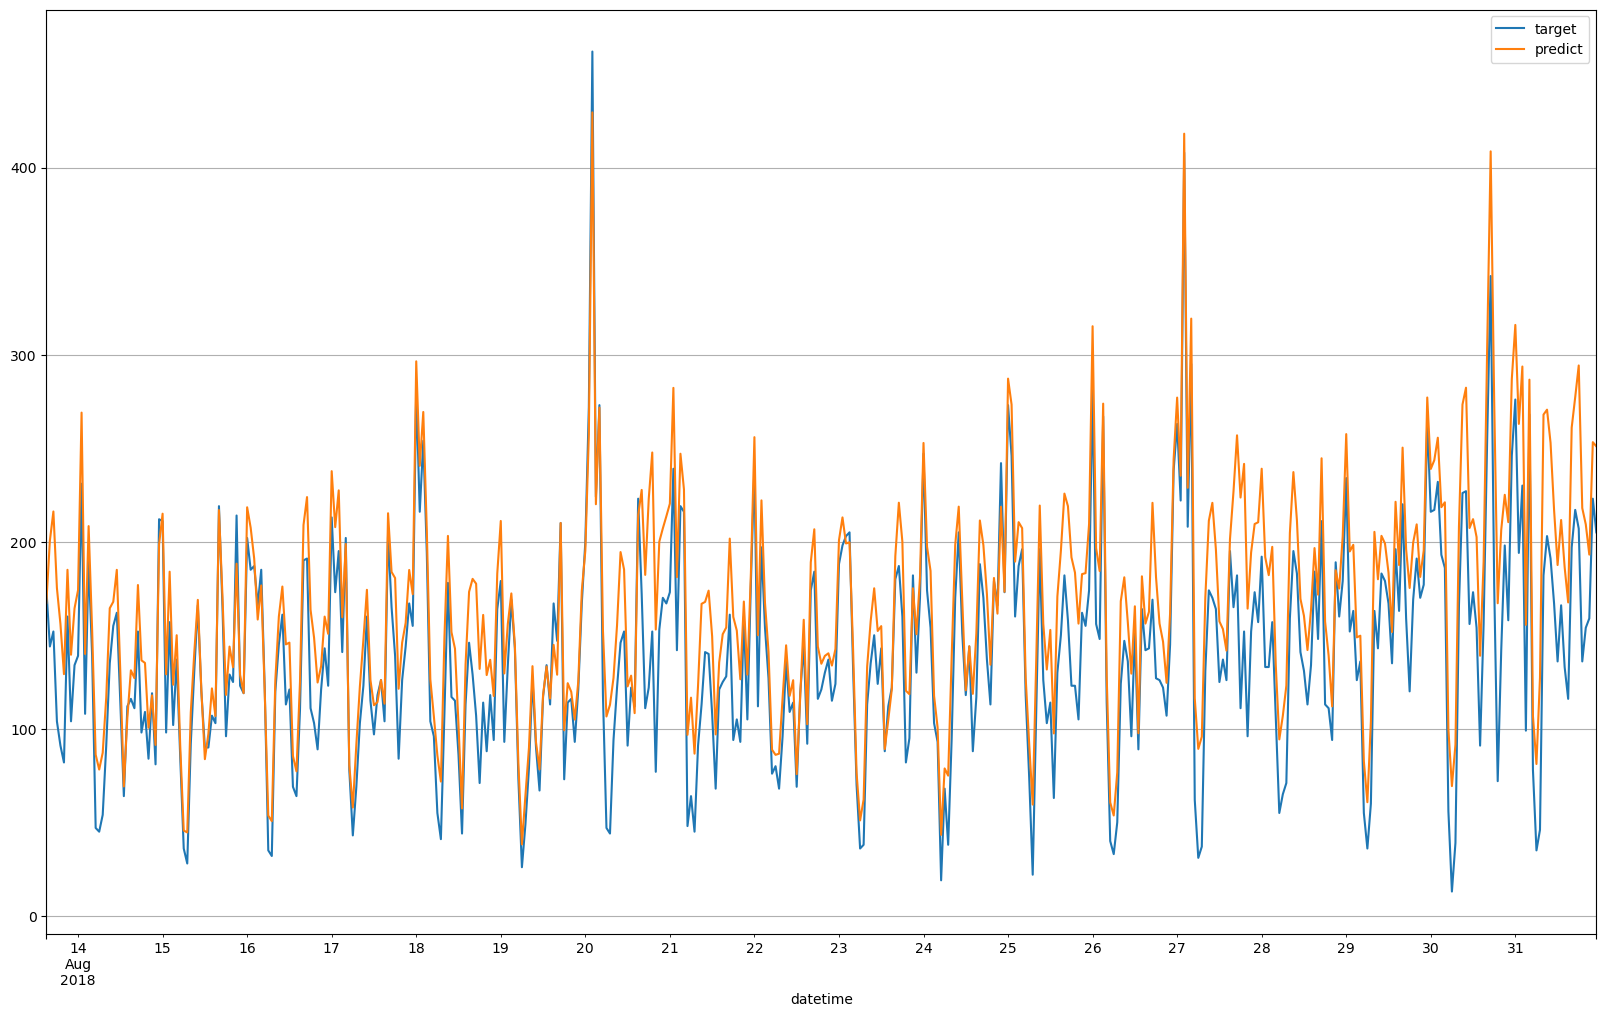

In [66]:
df.plot(figsize=(20, 12), grid=True);

График слижком плотный, но даже на нем видны актуальные и предсказанные значения.

Можно немного детализировать визуализацию.

**Тестовый период в диапазоне одного дня с 00 часов 15-08-2018 по 00 часов 16-08-2018.**

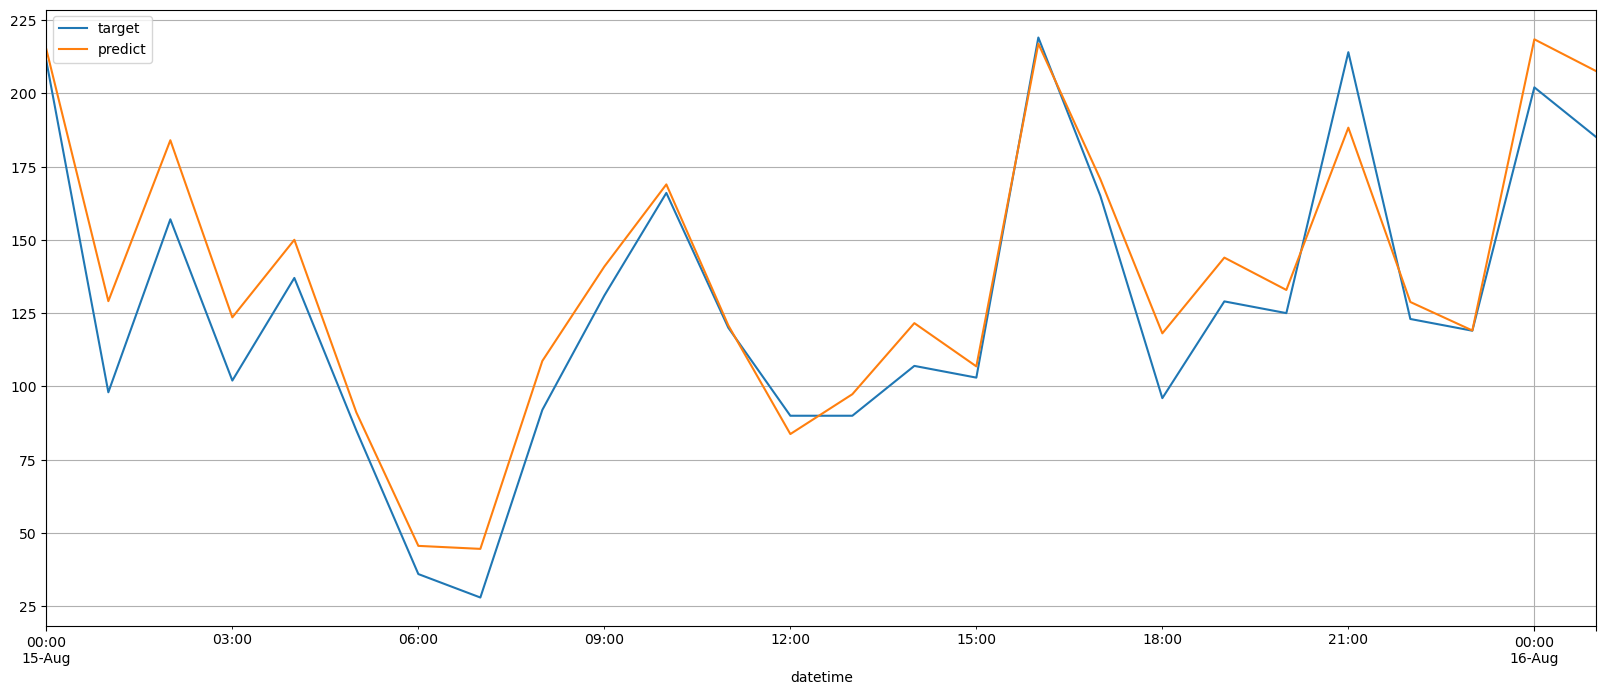

In [67]:
df['2018-08-15 00:00:00':'2018-08-16 01:00:00'].plot(figsize=(20, 8), grid=True);

Видно, что модель ошибается больше в сторону увеличения значений.

**Гистограмма этого же периода в диапазоне одного дня с 00 часов 15-08-2018 по 00 часов 16-08-2018.**

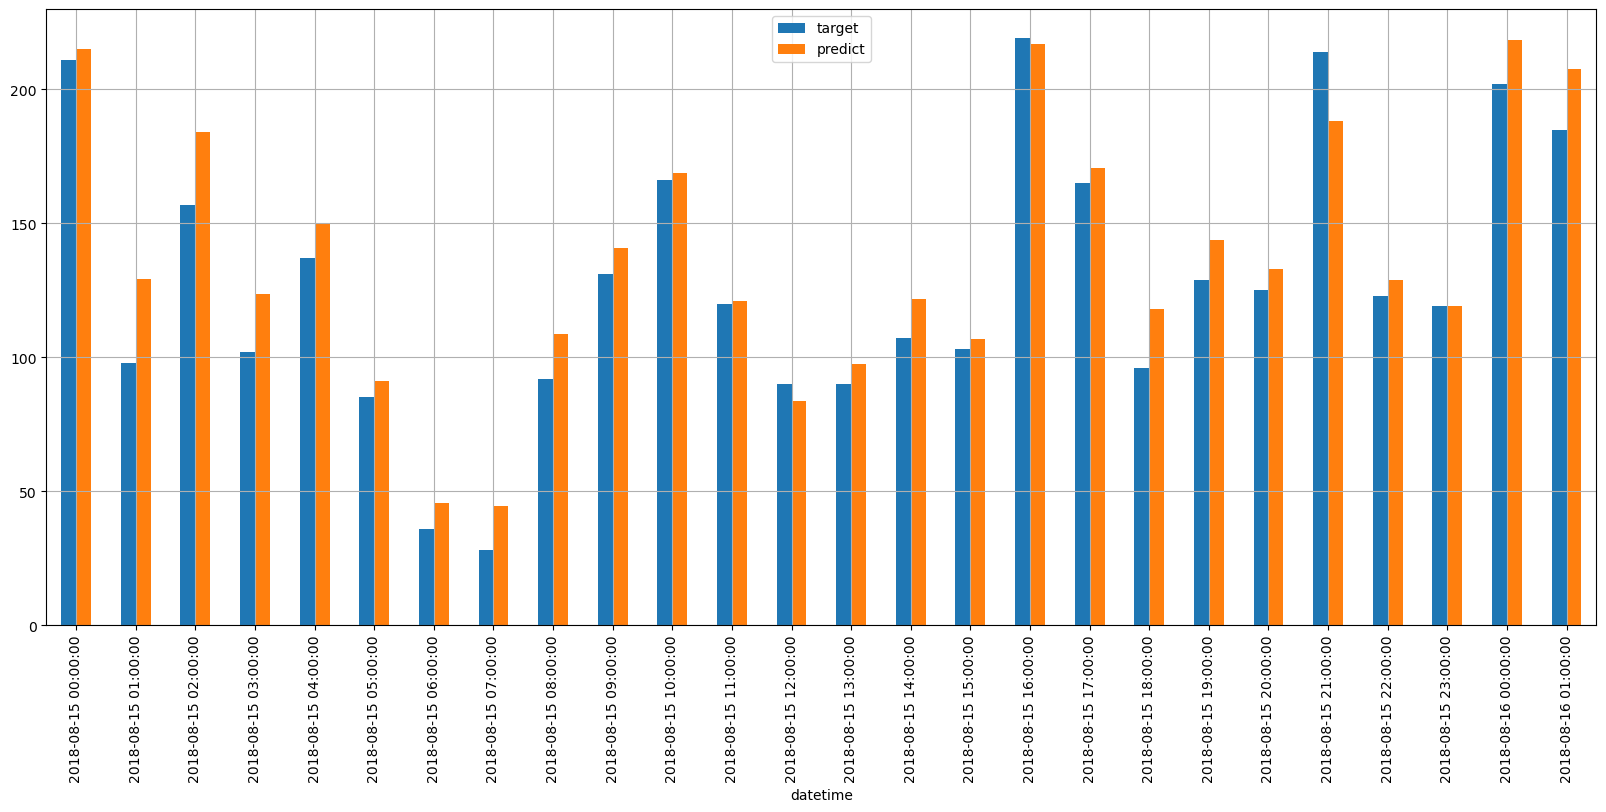

In [68]:
df['2018-08-15 00:00:00':'2018-08-16 01:00:00'].plot(figsize=(20, 8), grid=True, kind='bar');

Модель на тестовой выборке показала адекватный результат с ошибкой в 34.45 заказов.

## Вывод

К сожалению временной ряд был изначально сильно урезанный. Данные были только за весну-лето 2018 года. Оствутствуют данные за осень и зиму. И как минимум еще нужен хотя бы полный год наблюдений со всеми сезонами.

В результате исследования был проведен анализ данных, декомпозиция даных по тренду, сезонности и остаткам декомпозиции.

Проализирован времемнной ряд на стационарность. Ряд оказался стационарным.

Добавлены следующие признаки для моделирования:

- месяц;
- день;
- день недели;
- час;
- лаги - **7** штук;
- скользящее среднее - **`EMA`** (`exponential moving average`) c периодом **7**;
- скользящее среднее по последнему лагу.

Обучены следующие модели:

- `DecisionTreeRegressor`;
- `RandomForestRegressor`;
- `SGDRegressor`;
- `LGBMRegressor`;
- `Полносвязанная нейронная сеть`.

Лучший результат у нейросети c параметрами:

- 1 скрытый слой: 13 входных нейронов, 8 скрытых нейронов, 1 выходной нейрон;
- размер батча 32;
- скорость обучения 0.01;
- в нейросети использован алгоритм ранней остановки во избежание переобучения;
- шаг между эпохами - 100;
- применялась нормализация батча `BatchNorm1D`.

**RMSE** на валидации - **13.19**
**RMSE** на тесте - **34.45**.

В итоге ошибка всего в 34.45 заказов, что существенно лучше заданной метрики по условию в 48.